In [39]:
from Favorfit_image_to_text import clip_image_to_text

clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

In [1]:
from diffusers import KandinskyV22InpaintPipeline, KandinskyV22PriorPipeline
from diffusers.utils import load_image, make_image_grid
import torch
from PIL import Image

prior_pipeline = KandinskyV22PriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16, use_safetensors=True).to("cuda")
pipeline = KandinskyV22InpaintPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16, use_safetensors=True).to("cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


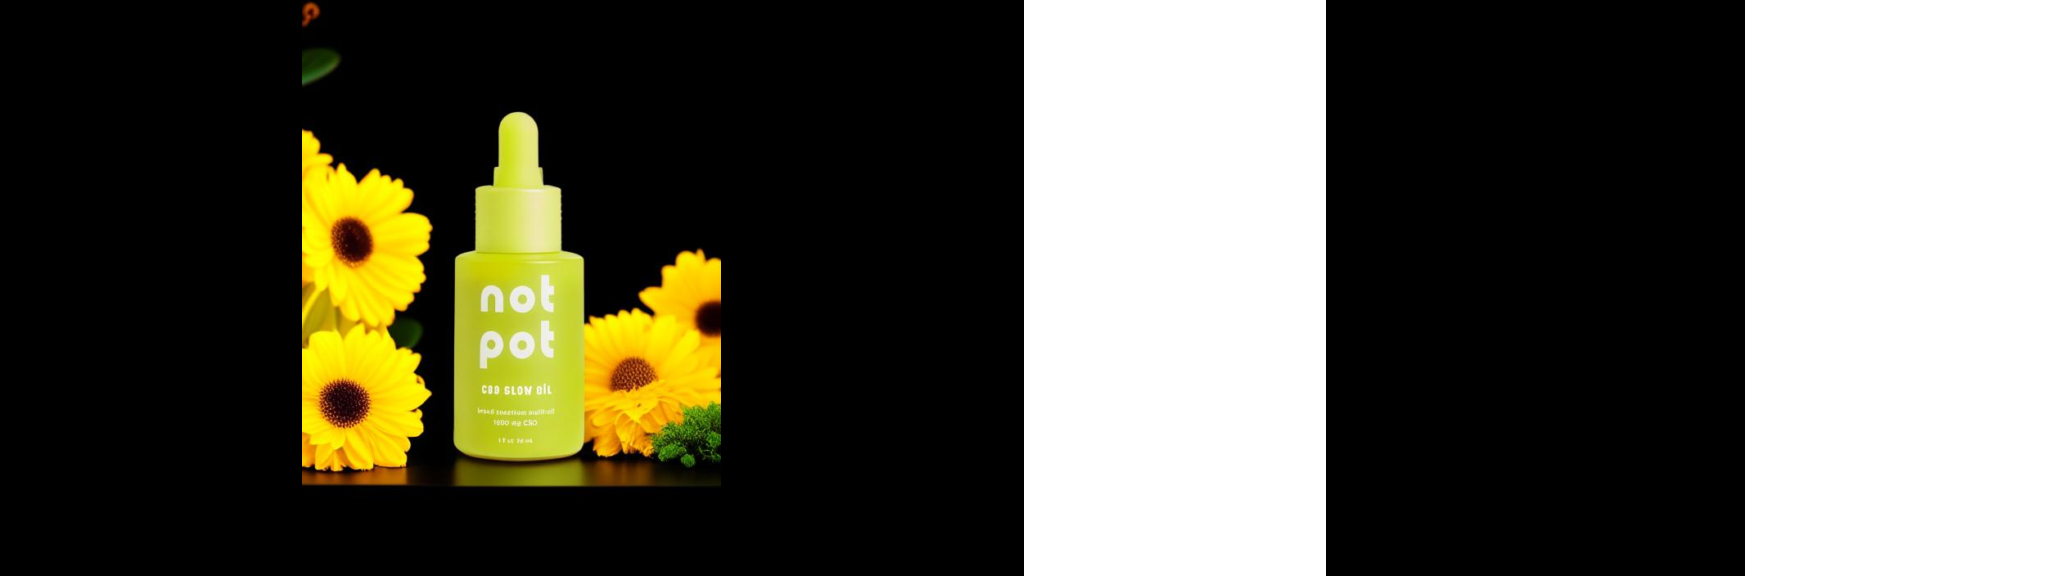

In [35]:
from diffusers.utils import make_image_grid

def resize_and_fill(image_path, desired_size):
    # 이미지 열기
    image = Image.open(image_path)

    # 이미지를 원하는 크기로 조정
    image.thumbnail(desired_size, Image.BILINEAR)

    # 검은색 배경 이미지 생성
    new_image = Image.new("RGB", desired_size, color="black")

    # 이미지를 중앙에 배치
    position = ((desired_size[0] - image.size[0]) // 2, (desired_size[1] - image.size[1]) // 2)
    new_image.paste(image, position)

    mask = Image.new("RGB", desired_size, color="white")
    mask.paste(Image.new("RGB", image.size, color="black"), position)

    return new_image, mask

image_path = "./output/outpaint/not_pot_perform/yellow flowers plants background_0.jpg"
desired_size = (1024, 576)

init_image, mask = resize_and_fill(image_path, desired_size)
make_image_grid([init_image, mask], cols=2, rows=1)

In [90]:
import random

important_keywords = ", natural materials :: high detail, behance. polished, trending on textures. com, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website"
caption = clip_image_to_text.inference(init_image, clip_model, mode="fast")
print(caption)

seed = random.randint(0,10000)

a bottle of cb cb cb cb cb cb cb cb cb cb cb cb, diffused natural skin glow, image on the store website, product introduction photo, high radiosity dull skin, product introduction photos, official product photo, official product image, skincare, skin care, nft, popular korean makeup, productphoto, no green, product advertisement, glowing oil


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['materials :: high detail, behance. polished, trending on textures. com, clean 3 d render, raytraced 3 d set design, raytracing shadows, image on the store website', '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>']
  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:05<00:00,  8.70it/s]


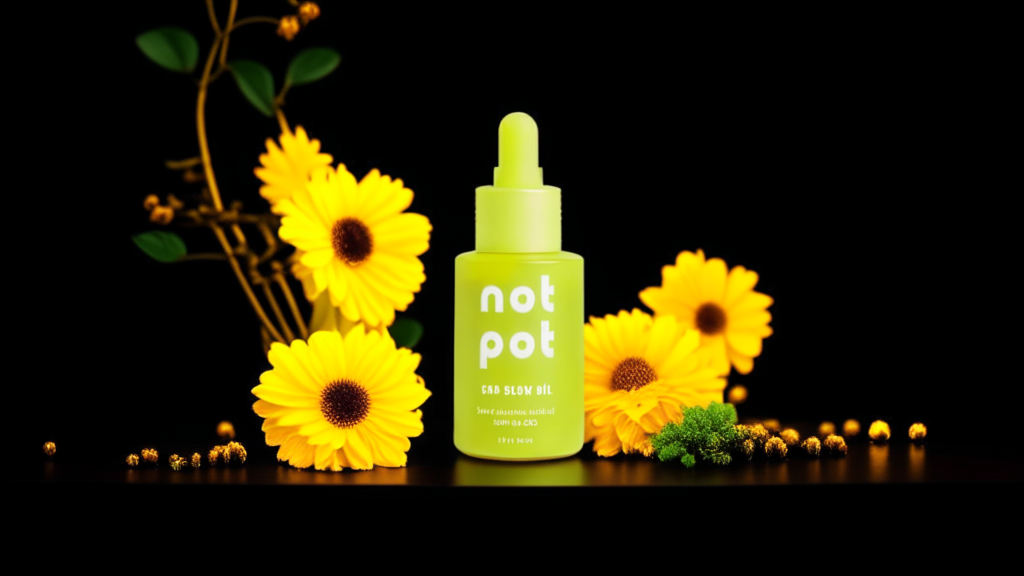

In [91]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

generator = torch.Generator(device="cuda").manual_seed(seed)

prior_output = prior_pipeline(
    prompt=f"{caption}" + important_keywords,
    negative_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    generator=generator
    )
output_image = pipeline(image=init_image, 
                        mask_image=mask, 
                        **prior_output, 
                        height=desired_size[1], 
                        width=desired_size[0], 
                        num_inference_steps=50,
                        strength=1.0,
                        guidance_scale=2.5,
                        generator=generator).images[0]


output_image

In [93]:
output_image.save("./output/extend/not_pot.jpg")